In [1]:
import time
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

def data_load(path):
    files = glob.glob(path)
    if not files:
        print("Chck Path")
        sys.exit()

    _feature=[]
    label=[]
    count = 0
    for address in tqdm.tqdm(files):
        if count ==0:
            _feature=np.array([np.load(address)])
            label_ = os.path.basename(address)[:-4].split('_')[-1]
            label.append([label_])
            count = count + 1
        label_ = os.path.basename(address)[:-4].split('_')[-1]

        _feature=np.append(_feature, np.array([np.load(address)]),axis=0)
        label.append([label_])

    target = np.array(label).flatten()
    return _feature, target.reshape((-1,1))



X_train, y_train = data_load('../data/train_set/*')
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train)

100%|██████████| 1110/1110 [01:11<00:00, 15.44it/s]


In [2]:
X_test, y_test = data_load('../data/test_set/*')
y_test = scaler.transform(y_test)


X_train,  X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3,stratify=y_train)
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0


100%|██████████| 37/37 [00:00<00:00, 110.75it/s]


In [3]:
tensorflow.random.set_seed(7)

Conv_default = partial(keras.layers.Conv2D,
                        kernel_size=3,padding="SAME")
model = keras.models.Sequential([
    Conv_default(filters=64, kernel_size=3, input_shape=[512, 512, 1]),
    keras.layers.Activation("relu"),
    Conv_default(filters=64),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    Conv_default(filters=128),
    keras.layers.Activation("relu"),
    Conv_default(filters=128),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    Conv_default(filters=256),
    keras.layers.Activation("relu"),
    Conv_default(filters=256),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),
    #
    Conv_default(filters=512),
    keras.layers.Activation("relu"),
    Conv_default(filters=512),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    Conv_default(filters=512),
    keras.layers.Activation("relu"),
    Conv_default(filters=512),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1),
])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model.compile(loss="mse", optimizer=keras.optimizers.Adam(0.0001),
              metrics=["mse"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 512, 512, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 512, 512, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 128)     0

In [ ]:
start = time.time()

history = model.fit(X_train, y_train,batch_size=16 ,epochs=300, callbacks=[callback], validation_data=(X_valid, y_valid))
print('Time :', time.time()-start)
score = model.evaluate(X_test,y_test)
print(score)


model.save("VGG2.h5")
np.save('history.npy',history.history)

In [4]:
history=np.load('history.npy',allow_pickle='TRUE').item()

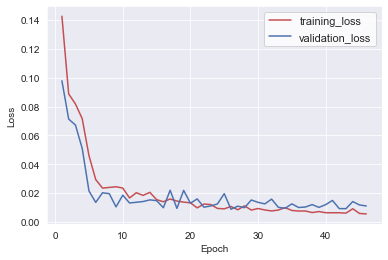

In [5]:
fig, ax = plt.subplots()
sns.set_theme(style="whitegrid")
training_loss = history["loss"]
test_loss = history["val_loss"]
epoch_count = range(1, len(training_loss)+1)


ax.plot(epoch_count, training_loss, "r-")
ax.plot(epoch_count, test_loss, "b-")
plt.legend(["training_loss", "validation_loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.savefig('../figure/loss_valid_change.png',dpi=300,bbox_inches='tight')